# 1. PREDICTING NEW LISTING PRICE FOR AIRBNB RENTALS, KNN
---
As an AirBnB host I want to:
- find listings that are similar to mine
- average the listings' prices 
- set my place's price to the averaged price

This makes sure that I don't lose business because my price is too high but it also makes sure that I don't lose money because I set the price too low.

Machine Learning Model: `K-Nearest Neighbors` - unsupervised model

Data: 
- [Inside AirBnB](http://insideairbnb.com/get-the-data.html)
    - `October 3, 2015: listings.csv.gz` Archived
- Dataquest.io: `dc_airbnb.csv`
    - Cleaned to keep the essential columns only (from 92 to 19)

## 1. Introducing the data

In [1]:
import pandas as pd
import numpy as np

dc = pd.read_csv('data/dc_airbnb.csv')

In [2]:
len(dc.columns)

19

In [3]:
dc.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'accommodates', 'room_type', 'bedrooms', 'bathrooms', 'beds', 'price',
       'cleaning_fee', 'security_deposit', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'latitude', 'longitude', 'city', 'zipcode',
       'state'],
      dtype='object')

In [4]:
dc.shape

(3723, 19)

In [5]:
dc = dc[['accommodates', 'price']]
dc.head()

,accommodates,price
0,4,$160.00
1,6,$350.00
2,1,$50.00
3,2,$95.00
4,4,$50.00


In [6]:
# display first row
dc.iloc[0]

accommodates          4
price           $160.00
Name: 0, dtype: object

## 2. Euclidian distance

Here's the strategy I wanted to use:
- Find a few similar listings.
- Calculate the average nightly rental price of these listings.
- Set the average price as the price for my listing.

When trying to predict a continuous value, like price, the main similarity metric that's used is Euclidean distance.
$$
d = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + ... + (q_n - p_n)^2}
$$

In my case, since I am using one feature, the *univariate Euclidian distance* is:
$$
d = |q_1 - p_1|
$$

The living space that I want to rent can accommodate 3 people. I will first calculate the distance, using just the `accommodates` feature, between the first living space in the dataset and my own.

In [7]:
my_acc = 3
acc_1st = dc.iloc[0]['accommodates']
euclid_1 = np.abs(acc_1st - my_acc)
euclid_1

1

- The lowest value $d$ can have is 0, meaning that $q_1 = p_1$
- The closer to 0 the distance, the more similar the living spaces are
- I can calculate the distance between my place and each place in the dataset and rank the result by ascending distance values
    - The higher the ranking, the higher the similarity

In [8]:
dc['euclid'] = dc['accommodates'].apply(
    lambda x: np.abs(x - my_acc))
dc['euclid'].value_counts()

1     2294
2      503
0      461
3      279
5       73
4       35
7       22
6       17
9       12
13       8
8        7
12       6
11       4
10       2
Name: euclid, dtype: int64

- There are 461 places that can accommodate 3 people, just like my place
- I will now select only these entries

In [9]:
dc[dc['euclid'] == 0]['accommodates']

26      3
34      3
36      3
40      3
44      3
       ..
3675    3
3697    3
3707    3
3714    3
3722    3
Name: accommodates, Length: 461, dtype: int64

## 3. Randomizing and sorting

- If I selected the first 5 living spaces with a eaclidian distance of 0, I would be biasing the result to the ordering of the dataset
- Instead I will randomize the ordering of the dataset and then sort the dataset by the `euclid` column
    - This means that all of the similar places will still be on top but in random order across the first 461 rows

In [10]:
np.random.seed(1)
dc = dc.loc[np.random.permutation(len(dc))]
dc = dc.sort_values('euclid')
dc.iloc[0:10]['price']

577     $185.00
2166    $180.00
3631    $175.00
71      $128.00
1011    $115.00
380     $219.00
943     $125.00
3107    $250.00
1499     $94.00
625     $150.00
Name: price, dtype: object

## 4. Calculating average price
- Before I can select the 5 most similar living spaces and compute the average price, I need to clean the price column. 
- Right now, the price column 
    - contains comma characters (,) and dollar sign characters and 
    - is formatted as a text column instead of a numeric one. 
- I need to remove these values and convert the entire column to the float datatype. 
- Then, I can calculate the average price.

In [11]:
remove_comma = dc['price'].str.replace(',', '')
remove_dollar = remove_comma.str.replace('$', '')
dc['price'] = remove_dollar.astype('float')
avg_price = dc.iloc[0:5]['price'].mean()
avg_price

156.6

Based on the average price of other listings that accommdate 3 people, I should charge **$156.6** per night for a guest to stay at my living space.

## 5. Designing prediction functions
I will now write 3 general functions that will help me do the following:
- clean the `price` column of the dataframe
- randomize and sort the dataframe
- suggest the optimal price for other values of the `accommodates` column. 

In [12]:
# data-cleaning function
def price_cleaner(df):
    no_comma = df['price'].str.replace(',', '')
    no_dollar = no_comma.str.replace('$', '')
    df['price'] = no_dollar.astype('float')
    return df

# randomizing-and-sorting function
def random_sorter(df):
    np.random.seed(1)
    df = df.loc[np.random.permutation(len(df))]
    return df

# price-predicting function
def price_predictor(df, listing):
    df_copy = df.copy()
    df_copy['euclid'] = df_copy['accommodates'].apply(
        lambda x: np.abs(x - listing))
    df_copy = df_copy.sort_values('euclid')
    KNN_5 = df_copy.iloc[0:5]['price']
    listing_price = KNN_5.mean()
    return listing_price

In [13]:
dc_1 = pd.read_csv('data/dc_airbnb.csv')
dc1_clean = price_cleaner(dc_1)
dc1_sorted = random_sorter(dc1_clean)
acc_n_price = price_predictor(dc1_sorted, 3)
acc_n_price

156.6

## 6. Analyzing predicted prices

In [14]:
# create a new dataframe
listings = pd.DataFrame() 

# add column of n people to accomodate
listings['n_acc'] = np.arange(1,13)

In [15]:
# create empty list to populate calculated prices
m_list = []
for n in np.arange(1,13):
    m = price_predictor(dc1_sorted, n)
    m_list.append(m)

# new dataframe for prices
listings_ = pd.DataFrame()
listings_['n_price'] = m_list

# add prices to listings df
listings['n_price'] = listings_['n_price']

# show listings
listings

,n_acc,n_price
0,1,68.0
1,2,112.8
2,3,156.6
3,4,124.8
4,5,230.8
5,6,183.2
6,7,306.6
7,8,288.8
8,9,286.8
9,10,404.6


<AxesSubplot:xlabel='n_acc', ylabel='n_price'>

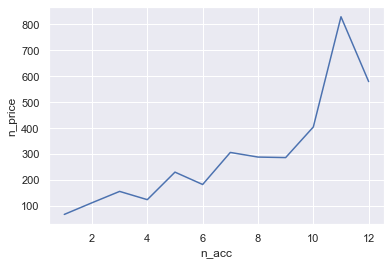

In [16]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.lineplot(x='n_acc', y='n_price', data=listings)

Generally speaking, as the number of people a listing can accommodate, the price goes up. This makes sense. However, when n=11 the price is abnormally high.

This could be due to the fact that we don't have enough data to accurately predict the price. It could also be because we are averaging only the first 5 neighbors which is prone to being sensitive to outliers. 

## 7. Upgrading the price-predicting function

Now, I can edit the `price_predictor` function to actually return the `listings` dataframe above:

In [17]:
# price-predicting function, upgraded
def price_predictor_2(df):
    df_copy = df.copy()
    n_acc = np.arange(1,13)
    n_price = []
    for n in n_acc:
        df_copy['euclid'] = df_copy['accommodates'].apply(
            lambda x: np.abs(x - n))
        df_copy = df_copy.sort_values('euclid')
        KNN_5 = df_copy.iloc[0:5]['price']
        m = KNN_5.mean()
        n_price.append(m)
    new_listings = pd.DataFrame()
    new_listings['n_acc'] = n_acc
    new_listings['n_price'] = n_price
    return new_listings

In [18]:
dc_1 = pd.read_csv('data/dc_airbnb.csv')
dc1_clean = price_cleaner(dc_1)
dc1_sorted = random_sorter(dc1_clean)
acc_n_price = price_predictor_2(dc1_sorted)
acc_n_price

,n_acc,n_price
0,1,68.0
1,2,83.8
2,3,107.8
3,4,145.0
4,5,191.6
5,6,204.6
6,7,389.8
7,8,281.2
8,9,294.8
9,10,388.6


This is awesome! Glad it could be done!

<AxesSubplot:xlabel='n_acc', ylabel='n_price'>

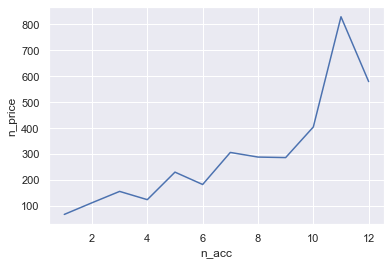

In [19]:
sns.lineplot(x='n_acc', y='n_price', data=listings)

## 8. Creating a Price-Cleaning Custom Transformer

So I want to be able to open a data file, do all kinds of preliminary work, and predict prices for various accommodation values through a pipeline. For that I need to create custom transformers; the first one being `PriceCleaner` transformer. Once I load the data and name the dataframe, this transformer will:
- pick only two columns to use: `accommodates` and `price`
    - the new dataframe is made from a copy of the original to avoid changes on the original
- clean the `price` column by removing commas and dollar signs and set it as a float
- return the cleaned dataframe with two columns

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class PriceCleaner(BaseEstimator, TransformerMixin):    
    def __init__(self, df=True):
        print('\n>>>>>>>init() called.\n')
        self.df = df

    def fit(self, df, y = None):
        print('\n>>>>>>>fit() called.\n')        
        return self

    def transform(self, df):
        print('\n>>>>>>>transform() called.\n')
        cols = ['accommodates', 'price']
        df = df[cols].copy()
        no_comma = df['price'].str.replace(',', '')
        no_dollar = no_comma.str.replace('$', '')
        df['price'] = no_dollar.astype('float')
        self.df = df[cols]
        return df

Clealy the transformer works pretty well. 
- the prints were added to check that every step is being called
- by creating a pipeline with one step, I see that the `PriceCleaner` transformer did exactly what it was designed to do
- *Awesome!*

In [28]:
from sklearn.pipeline import Pipeline

dc_1 = pd.read_csv('data/dc_airbnb.csv')
pipe = Pipeline(steps = [
    ('clean_price', PriceCleaner())])

dc1_clean = pipe.fit_transform(dc_1)
dc1_clean.head()


>>>>>>>init() called.


>>>>>>>fit() called.


>>>>>>>transform() called.



,accommodates,price
0,4,160.0
1,6,350.0
2,1,50.0
3,2,95.0
4,4,50.0
